### Imports

In [138]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [139]:
import dlib
import cv2
import math
from google.colab.patches import cv2_imshow

### Calculate Eye Aspect Ratio(EAR)

In [140]:
def distance(p1, p2):
  return math.sqrt((p1.x - p2.x)**2 + (p1.y - p2.y)**2)

In [141]:
# Function to calculate Eye Aspect Ratio (EAR) based on facial landmarks
def calculate_ear_from_landmarks(landmarks):
    # Extracting coordinates of the eyes, this coordinates need to be fine tuned for EAR calculations
    left_eye = [landmarks.part(i) for i in range(36, 42)]  # Indices 36 to 41 correspond to the left eye
    right_eye = [landmarks.part(i) for i in range(42, 48)]  # Indices 42 to 47 correspond to the right eye
    print(distance(left_eye[0],left_eye[3]))
    # Calculating EAR
    left_ear = (distance(left_eye[1],left_eye[5]) + distance(left_eye[2], left_eye[4])) / (2.0 * distance(left_eye[0],left_eye[3]))
    right_ear = (distance(right_eye[1], right_eye[5]) + distance(right_eye[2], right_eye[4])) / (2.0 * distance(right_eye[0], right_eye[3]))
    # Overall EAR is the average of left and right EAR
    ear = (left_ear + right_ear) / 2.0
    return ear

## Detecting the landmarks

In [142]:
def detect_landmarks(image):
  detector = dlib.get_frontal_face_detector()
  predictor = dlib.shape_predictor("/content/drive/MyDrive/Facial Landmarks/shape_predictor_68_face_landmarks.dat")  # Replace with the actual path
  faces = detector(image)
  try:
    landmarks = predictor(image, faces[0])
    return landmarks
  except:
    return None

In [147]:
def eye_land_marks(img, landmarks,color):
  for i in range(36,48):
      x, y = landmarks.part(i).x, landmarks.part(i).y
      cv2.circle(img, (x, y), 1, color, -1)  # Green color
  return img

def mouth_land_marks(img, landmarks):
  for i in range(48,61):
      x, y = landmarks.part(i).x, landmarks.part(i).y
      cv2.circle(img, (x, y), 1, (0,255,0), -1)  # Green color
  return img

### To Crop
```
x coordinate of 42: x coordinate of 26 --> width
y coordinate of 26: y coordinate of 47 --> height
```
```
image[landmarks.part(42).x:landmarks.part(26).x, landmarks.part(26).y:landmarks.part(47).y]
```

In [171]:
def eye_extract(img,landmarks, color=(255,255,255), scale=1.0, thickness=1, box = False, crop=False):
  # ideal eye bounding box coordinates
  coordinates = {
      "right_start":(int(landmarks.part(26).x/scale), int(landmarks.part(26).y/scale)),
      "right_end": (int(landmarks.part(22).x/scale), int(landmarks.part(28).y/scale)),
      "left_start": (int(landmarks.part(21).x/scale), int(landmarks.part(21).y/scale)),
      "left_end": (int(landmarks.part(17).x/scale), int(landmarks.part(28).y/scale))
  }
  # just get the bounding box image
  if box:
    box = cv2.rectangle(img.copy(), coordinates["right_start"], coordinates["right_end"], color, thickness)
    box = cv2.rectangle(box, coordinates["left_start"], coordinates["left_end"], color, thickness)
    return box

  # crop code
  elif crop:
    res = []
    crop_left = img[coordinates["left_start"][1]: coordinates["left_end"][1], coordinates["left_end"][0]:coordinates["left_start"][0]]
    crop_right = img[coordinates["right_start"][1]: coordinates["right_end"][1], coordinates["right_end"][0]:coordinates["right_start"][0]]
    res.append(crop_left)
    res.append(crop_right)
    return res
  # get both
  else:
    res = []
    box = cv2.rectangle(img.copy(), coordinates["right_start"], coordinates["right_end"], color, thickness)
    box = cv2.rectangle(box, coordinates["left_start"], coordinates["left_end"], color, thickness)
    crop_right = img[coordinates["right_start"][1]: coordinates["right_end"][1], coordinates["right_end"][0]:coordinates["right_start"][0]]
    crop_left = img[coordinates["left_start"][1]: coordinates["left_end"][1], coordinates["left_end"][0]:coordinates["left_start"][0]]
    res.append(box)
    res.append(crop_left)
    res.append(crop_right)
    return res

### Process all the functions

In [180]:
def process(path):
  image = dlib.load_rgb_image(path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  original = image.copy()
  scale = 0.3
  image = cv2.resize(image, (0, 0), fx = scale, fy = scale)
  landmarks = detect_landmarks(image)
  if landmarks:
    ear_value = calculate_ear_from_landmarks(landmarks)
    print("Eye Aspect Ratio:", ear_value)
    # Draw landmarks with specified color
    threshold = 0.25
    croppable = False
    if ear_value>threshold:
      color = (0,255,0)
      croppable = True
    else:
      color = (0,0,255)
      croppable = False
    # Display the image with landmarks
    print("Landmarks:")
    cv2_imshow(eye_land_marks(image.copy(),landmarks, color = color))
    cv2_imshow(mouth_land_marks(image.copy()),landmarks)
    box = eye_extract(original,landmarks, color = color, scale=scale, box=True)
    print("Bounding box ROI:")
    cv2_imshow(box)
    # crop eyes
    if croppable:
      left, right = eye_extract(original,landmarks, color=color, scale=scale, crop=True)
      print("Left Eye")
      cv2_imshow(left)
      print("Right Eye")
      cv2_imshow(right)
  else:
    print("No faces Detected!")

Path to image: /content/drive/MyDrive/Facial Landmarks/Drive-_-chronique-e1606150466516.webp
9.0
Eye Aspect Ratio: 0.31666666666666665
Landmarks:


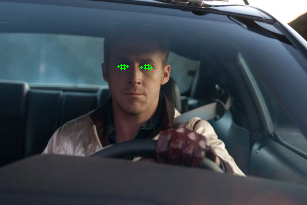

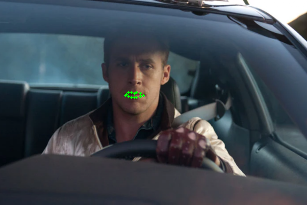

Bounding box ROI:


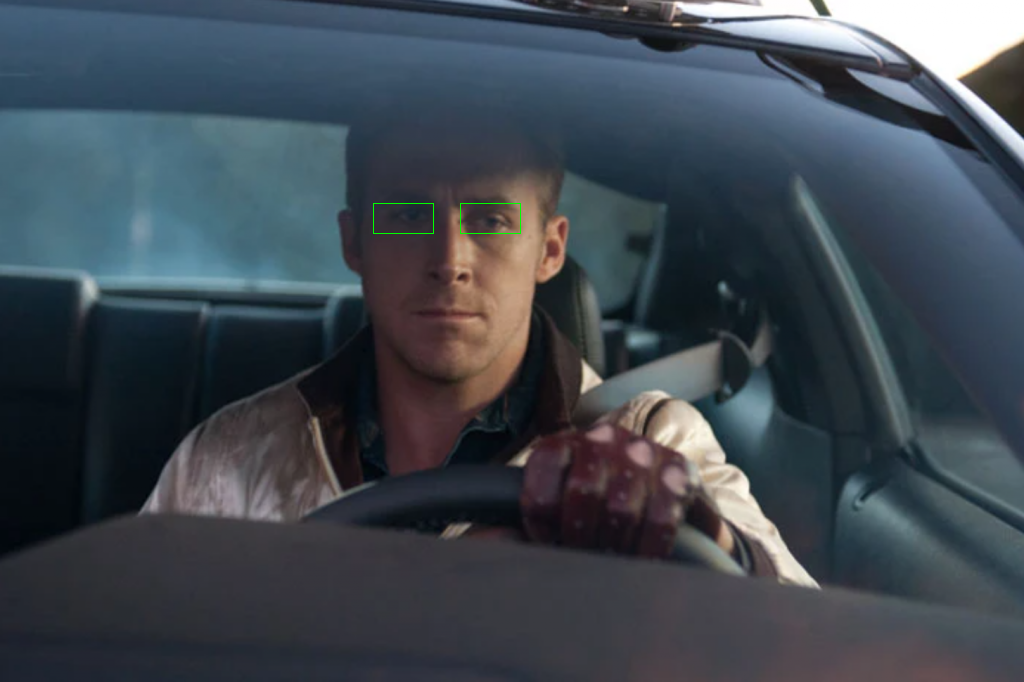

Left Eye


Right Eye


In [181]:
if __name__ == "__main__":
  process(input("Path to image: "))

**backup**

```python
def eye_bounding_boxes(image, color=(255,255,255), thickness=1, crop=False):
  #idealeye bounding box coordinates
  coordinates = {
      "right_start":(landmarks.part(45).x,landmarks.part(26).y),
      "right_end": (landmarks.part(42).x, landmarks.part(47).y),
      "left_start": (landmarks.part(45-6).x,landmarks.part(26).y),
      "left_end": (landmarks.part(42-6).x, landmarks.part(47).y)
  }

  box = cv2.rectangle(image.copy(), coordinates["right_start"], coordinates["right_end"], color, thickness)
  box = cv2.rectangle(box, coordinates["left_start"], coordinates["left_end"], color, thickness)
  # crop code
  if crop:
    crop_right = image[coordinates["right_start"][1]: coordinates["right_end"][1], coordinates["right_end"][0]:coordinates["right_start"][0]]
    crop_left = image[coordinates["left_start"][1]: coordinates["left_end"][1], coordinates["left_end"][0]:coordinates["left_start"][0]]
    return box, crop_left,crop_right
  return box

eye_detected, left, right = eye_bounding_boxes(image.copy(), color = color, crop=True)
cv2_imshow(eye_detected)
```